In [164]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Some Functions and Classes

In [ ]:
def calculate_rolling_betas(stock_returns: pd.DataFrame, factor_returns: pd.DataFrame, lookback=36, min_periods=12):
    """Calculate rolling betas for each stock against each factor individually.

    Args:
        stock_returns (pd.DataFrame): _description_
        factor_returns (pd.DataFrame): _description_
        lookback (int, optional): _description_. Defaults to 36.
        min_periods (int, optional): _description_. Defaults to 12.

    Returns:
        _type_: _description_
    """
    assert (stock_returns.index == factor_returns.index).all()

    betas = {}

    rolling_returns = stock_returns.rolling(lookback, min_periods=min_periods)  # returns in shape (rows=monthid, cols=stock)

    for f in factor_returns:
        print(f"Computing exposures for {f}...")

        factor_return_series = factor_returns[f]

        # beta = cov(stock_return, factor_return) / factor_return.var()
        rolling_cov = rolling_returns.cov(factor_return_series)
        rolling_betas = rolling_cov.div(factor_return_series.rolling(lookback, min_periods=min_periods).var(), axis=0)
        betas[f] = rolling_betas.stack()
    
    print(f"Completed all regressions, joining results")
    all_betas = pd.concat(betas.values(), axis=1)
    all_betas.columns = betas.keys() 
    return all_betas

# Import and Prep Data

In [272]:
# data = pd.read_csv("assets.zip")
data = pd.read_parquet("assets.parquet")

## Generate 36 Month Rolling Betas

In [273]:
returns = data[["RET", "monthid", "PERMNO"]].pivot_table(values="RET", index="monthid", columns="PERMNO")

factors = data.drop_duplicates(subset=["DATEFF"]).drop(columns=["PERMNO", "RET", "DATEFF", "RF"]).set_index("monthid")

rolling_betas = calculate_rolling_betas(returns, factors, lookback=36, min_periods=12)

Computing exposures for SMB...
Computing exposures for HML...
Computing exposures for MKTRF...
Computing exposures for UMD...
Computing exposures for epq1...
Computing exposures for ioca...
Computing exposures for ra26...
Computing exposures for e11...
Computing exposures for Abr1...
Computing exposures for Re1...
Computing exposures for dRoe1...
Computing exposures for dRoa1...
Computing exposures for rnaq1...
Computing exposures for atoq1...
Computing exposures for dNoa...
Computing exposures for Nsi...
Computing exposures for dNca...
Computing exposures for dFnl...
Completed all regressions, joining results


## Winsorize and Scale

In [281]:
# TODO: winsorize betas grouped by industry?

In [284]:
# Functions to winsorize and scale
def winsorize(group):
    return group.clip(lower = group.mean() - 3 * group.std(), upper = group.mean() + 3 * group.std(), axis = 1)

import warnings
def min_max_scale(group):
    # ignore annoying NaN warnings, we will deal with all NaN groups later
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        scaler = sklearn.preprocessing.MinMaxScaler()
        scaled_data = scaler.fit_transform(group)
    return pd.DataFrame(scaled_data, index=group.index, columns=group.columns)

def z_score_scale(group):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        scaler = sklearn.preprocessing.StandardScaler()
        scaled_data = scaler.fit_transform(group)
    return pd.DataFrame(scaled_data, index=group.index, columns=group.columns)

In [285]:
# Group by date, then winsorize at +/- 3 std and scale betas
winsorized_betas = rolling_betas.groupby(level=0).apply(winsorize)
scaled_betas = winsorized_betas.groupby(level=0).apply(z_score_scale)
scaled_betas.head()

C:\Users\hughj\AppData\Local\Temp\ipykernel_7612\3145291451.py:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  winsorized_betas = rolling_betas.groupby(level=0).apply(winsorize)
C:\Users\hughj\AppData\Local\Temp\ipykernel_7612\3145291451.py:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  scale

SMB       HML     MKTRF       UMD      epq1      ioca  \
monthid PERMNO                                                               
12      10006   0.673559 -0.201737 -0.059525 -0.374869 -0.218703  0.282739   
        10102   0.963194  0.780831  0.782870 -0.689504 -0.443926  0.089670   
        10137   0.903894  0.531749  0.502677 -0.893659 -1.067003 -1.715637   
        10145  -0.282508 -0.246116 -0.130269  0.258035  0.703833  1.003924   
        10161   0.084534  0.102303  0.002224  0.061330 -0.757281  0.124961   

                ra26  e11      Abr1  Re1  dRoe1  dRoa1  rnaq1  atoq1  \
monthid PERMNO                                                         
12      10006    NaN  NaN -0.146598  NaN    NaN    NaN    NaN    NaN   
        10102    NaN  NaN  1.736403  NaN    NaN    NaN    NaN    NaN   
        10137    NaN  NaN  0.107113  NaN    NaN    NaN    NaN    NaN   
        10145    NaN  NaN -0.028612  NaN    NaN    NaN    NaN    NaN   
        10161    NaN  NaN  0.120903  NaN    NaN    NaN    NaN    NaN   

                    dNoa       Nsi      dNca      dFnl  
monthid PERMNO                                          
12      10006  -0.179720 -0.124800  0.107982  1.210066  
        10102  -0.363959 -0.016660 -1.032202 -1.629239  
        10137  -1.119216 -1.239890 -0.557119  1.012021  
        10145   0.239581  0.659358  0.142841  0.028869  
        10161   0.520350  0.144543  0.478335 -0.274891

In [286]:
scaled_betas.describe()

,SMB,HML,MKTRF,UMD,epq1,ioca,ra26,e11,Abr1,Re1,dRoe1,dRoa1,rnaq1,atoq1,dNoa,Nsi,dNca,dFnl
count,1.340635e+06,1.340635e+06,1.340635e+06,1.340635e+06,1.340635e+06,1.340635e+06,1.286375e+06,1.289470e+06,1.340635e+06,1.328539e+06,1.332180e+06,1.332180e+06,1.337764e+06,1.337764e+06,1.340635e+06,1.340635e+06,1.340635e+06,1.340635e+06
mean,-7.536666e-18,4.939643e-18,-1.696015e-19,-4.552740e-18,4.547440e-18,-3.805433e-18,2.132112e-18,-3.595502e-18,1.515813e-18,6.204030e-19,-9.387284e-19,3.637573e-18,-4.206645e-18,1.529689e-18,-1.939817e-18,-1.081209e-18,2.533422e-18,-2.721574e-18
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.659743e+00,-3.900459e+00,-4.145492e+00,-3.667948e+00,-3.799629e+00,-3.804288e+00,-4.456000e+00,-3.620603e+00,-4.345762e+00,-3.580976e+00,-4.562469e+00,-4.501538e+00,-5.455197e+00,-4.776845e+00,-3.806105e+00,-4.252333e+00,-3.778566e+00,-4.418918e+00
25%,-6.566247e-01,-5.306547e-01,-6.712033e-01,-5.360901e-01,-6.096852e-01,-6.362846e-01,-5.457571e-01,-5.138370e-01,-5.293106e-01,-5.104086e-01,-4.987928e-01,-5.008247e-01,-4.930893e-01,-5.898336e-01,-5.494686e-01,-6.513935e-01,-4.983239e-01,-5.014546e-01
50%,-1.474770e-01,1.055412e-01,-1.276641e-01,2.771483e-02,-1.205512e-01,-1.848675e-01,-3.342379e-02,7.084048e-02,-1.355080e-02,5.421952e-02,8.404376e-02,7.650498e-02,1.115630e-01,-5.696636e-02,-2.576982e-02,-1.654300e-01,1.191250e-01,7.173942e-02
75%,5.058304e-01,6.197491e-01,5.247301e-01,5.709578e-01,5.141700e-01,4.653272e-01,5.104453e-01,5.908784e-01,5.148844e-01,5.624954e-01,5.899868e-01,5.872903e-01,5.950002e-01,5.318373e-01,5.170860e-01,4.990265e-01,6.232470e-01,5.839844e-01
max,3.819221e+00,3.900134e+00,4.125873e+00,3.760521e+00,3.847699e+00,4.131817e+00,4.414565e+00,3.574747e+00,4.382414e+00,3.543255e+00,4.506185e+00,4.436873e+00,5.411323e+00,4.240081e+00,3.831738e+00,4.301038e+00,3.735665e+00,4.375914e+00


In [287]:
# Add forward returns and excess return
rf = data.set_index("monthid")["RF"]
rf = rf[~rf.index.duplicated()]  # rf indexed by monthid

xret = returns.sub(rf, axis=0)

fwd_xret = xret.shift(-1).stack()
fwd_xret.name = "XRET_T1"

fwd_ret = returns.shift(-1).stack()
fwd_ret.name = "RET_T1"

ml_data = scaled_betas.merge(fwd_xret, how="left", left_index=True, right_index=True)
ml_data = ml_data.merge(fwd_ret, how="left", left_index=True, right_index=True)

In [288]:
# IGNORE: Try predict rank of future returns, rather than returns themselves
# ml_data["XRET_T1"] = ml_data[["XRET_T1"]].groupby(level=0).apply(lambda g: min_max_scale(g.rank()))

# ml_data = ml_data.groupby(level=0).apply(lambda g: min_max_scale(g.rank()))

## Clean NaN

In [289]:
# clean data of NaN
# TODO: instead of dropping everything, follow the steps below

# 1) Drop NaN values in XRET_T1
# 2) Group by date, fill each NaN factor value with the mean factor value on that date. 
# 3) Drop any rows that are still NaN, or just fill with 0

# 4) Drop any leftover rows with NaN
ml_data = ml_data.dropna()

In [456]:
# TODO: I think this should be fwd_ret?
# actual_t1_returns = data.set_index(["monthid", "PERMNO"]).RET.sort_index()
actual_t1_returns = fwd_ret.copy()
actual_t1_returns.name = "ACTUAL_RET_T1"

## Final Data

In [278]:
ml_data.head()

SMB       HML     MKTRF       UMD      epq1      ioca  \
monthid PERMNO                                                               
12      10006   0.607605  0.466640  0.480544  0.440133  0.463581  0.520863   
        10102   0.654231  0.627372  0.620302  0.389205  0.426310  0.487134   
        10137   0.644685  0.586626  0.573816  0.356160  0.323200  0.171756   
        10145   0.453698  0.459381  0.468807  0.542577  0.616247  0.646850   
        10161   0.512784  0.516376  0.490788  0.510737  0.374455  0.493299   

                ra26  e11      Abr1  Re1  dRoe1  dRoa1  rnaq1  atoq1  \
monthid PERMNO                                                         
12      10006    NaN  NaN  0.475550  NaN    NaN    NaN    NaN    NaN   
        10102    NaN  NaN  0.788223  NaN    NaN    NaN    NaN    NaN   
        10137    NaN  NaN  0.517679  NaN    NaN    NaN    NaN    NaN   
        10145    NaN  NaN  0.495142  NaN    NaN    NaN    NaN    NaN   
        10161    NaN  NaN  0.519969  NaN    NaN    NaN    NaN    NaN   

                    dNoa       Nsi      dNca      dFnl   XRET_T1    RET_T1  
monthid PERMNO                                                              
12      10006   0.470512  0.482178  0.518266  0.700591  0.206339  0.211039  
        10102   0.440364  0.500017  0.330896  0.230491  0.193882  0.198582  
        10137   0.316775  0.298236  0.408968  0.667801  0.042597  0.047297  
        10145   0.539125  0.611531  0.523995  0.505022  0.235902  0.240602  
        10161   0.585069  0.526608  0.579127  0.454729  0.116993  0.121693

In [279]:
actual_t1_returns.head()

monthid  PERMNO
1        10006     0.231061
         10102     0.337349
         10137     0.333333
         10145     0.136564
         10161     0.215447
Name: ACTUAL_RET_T1, dtype: float64

In [280]:
rf.head()

monthid
1    0.0058
2    0.0043
3    0.0041
4    0.0044
5    0.0044
Name: RF, dtype: float64

# Run ML

In [293]:
OBJECTIVE = "XRET_T1"

# Use our selected features only
FEATURES = [
    'SMB', 'HML', 'MKTRF', 'UMD', 'epq1', 'ioca', 'Abr1', 'rnaq1', 'atoq1', 'Nsi', 'dNca', 'dFnl'
]

In [332]:
import math
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.exceptions import NotFittedError

# Predictions
def pred(model, x_train, y_train, x_test, y_test):
    # Fit model and predict. If the model is already fitted, use the existing trained model.
    try:
        pred = model.predict(x_test)
    except NotFittedError as e:
        print(f"Training Model...")
        model = model.fit(x_train, y_train)
        pred = model.predict(x_test)
    
    # Format prediction as DataFrame
    pred_df = pd.DataFrame(pred, columns = ['pred'])
    pred_df.set_index(x_test.index, inplace = True)
    
    r2 = r2_score(y_test, pred)
    return model, pred_df, r2

# Function to build the portfolio and calculate different performance metrics
def portfolio_build(df_pred: pd.DataFrame, model_name: str, actual_t1_returns: pd.Series, rf_month):
    """
    Params:
        df_pred: DataFrame indexed by [monthid, permno] with column "pred" for predicted T+1 returns
        model_name: Str cosmetic name
        actual_t1_returns: Series indexed by [monthid, permno] with actual T+1 returns
        rf_month: RF returns each month
    """
    actual_t1_returns.name = "ACTUAL_RET_T1"

    data = df_pred.merge(actual_t1_returns, how="left", left_index=True, right_index=True)

    portfolio_ret = []
    # index is monthid + 1, since these returns are for the start of the current period to end of next period, so month ending monthid+1
    index = []
    mth_grp = data.groupby('monthid')
    data['pred_rank'] = mth_grp["pred"].transform(lambda x: pd.qcut(x.rank(method="first"), 10, labels=False) if not np.isnan(x).all() else x)  # if statement in case all NaN
    for monthid, mdata in mth_grp:
      # TODO: can add value weighting of returns here if anyone needs it
      d1 = mdata[mdata['pred_rank'] == 0]['ACTUAL_RET_T1'].mean()
      d10 = mdata[mdata['pred_rank'] == 9]['ACTUAL_RET_T1'].mean()
      portfolio_ret.append(d10 - d1)
      index.append(monthid + 1)

    # Portfolio returns, indexed by monthid of the return end period
    ls_df = pd.DataFrame(portfolio_ret, index=index, columns=["ls_ret"])
    
    # Calculating cumulative returns
    # First we +1 to the returns 
    # Then we do the cumulative product
    ls_df['cumulative_ret']= ls_df['ls_ret'] + 1
    ls_df['cumulative_ret'] = ls_df['cumulative_ret'].cumprod()
    
    # Get mean/std/sharpe ratio for the portfolio
    ls_df = pd.merge(ls_df, rf_month, left_index = True, right_index = True)
    ls_df['ls_sub_rf'] = ls_df['ls_ret'] - ls_df['RF']
    ls_sub_rf_mean = ls_df['ls_sub_rf'].mean()*12
    ls_sub_rf_std = ls_df['ls_sub_rf'].std()*math.sqrt(12)
    sharpe_ratio = ls_sub_rf_mean/ls_sub_rf_std*math.sqrt(12)
    
    print(model_name + " excess return (ann): " + str(ls_sub_rf_mean))
    print(model_name + " volatility (ann): " + str(ls_sub_rf_std))
    print(model_name + " sharpe ratio (ann): " + str(sharpe_ratio))
    print()
    
    return ls_df, ls_sub_rf_mean, ls_sub_rf_std, sharpe_ratio

In [366]:
(551-372)/(551)

0.3248638838475499

In [355]:
ml_data

SMB       HML     MKTRF       UMD      epq1      ioca  \
monthid PERMNO                                                               
72      10006  -0.109735 -0.538261  0.391927  0.457078  0.454303 -0.487237   
        10057   0.998129  0.315587  0.884967 -0.184444  0.411016 -0.691117   
        10137  -1.293750  0.976564 -1.267547 -0.888997 -0.701667  0.981022   
        10145  -0.084149 -0.377755  0.352493  0.468150  0.382481 -0.630327   
        10153   0.159028 -0.123290 -0.405536 -0.300831 -0.463230  0.720569   
...                  ...       ...       ...       ...       ...       ...   
551     93397   0.046720 -0.147714 -0.188184  0.202589  0.128962  0.298311   
        93423   1.428994  1.058875  2.073598 -1.272547 -1.834209 -0.547077   
        93426   0.696540  0.299474  0.520306  0.008646 -0.302911  0.488533   
        93427  -0.098135 -0.349186 -0.205980  0.347479  0.315903 -0.232395   
        93436  -0.713387 -0.255849  1.470109 -0.189605 -0.015060 -1.239933   

                    ra26       e11      Abr1       Re1     dRoe1     dRoa1  \
monthid PERMNO                                                               
72      10006   1.077428  0.713842  0.563871  0.572279  0.813422  0.700650   
        10057   1.697109  0.057976 -0.421796  1.643252 -0.850298 -1.222003   
        10137  -0.482105 -0.886377 -0.757335 -0.963835 -0.757426 -0.618069   
        10145  -0.647532  0.897211  0.660697 -0.068117  0.677822  0.581785   
        10153  -0.037364 -0.825115 -0.769416 -0.062624 -0.541378 -0.690068   
...                  ...       ...       ...       ...       ...       ...   
551     93397  -0.281150  0.253570  0.553571  0.221557  0.251610  0.064427   
        93423   1.554256 -1.619860  0.128791 -2.272185 -2.073061 -1.766446   
        93426   0.050267  0.254790  0.272807 -0.117692  0.302263 -0.226348   
        93427   0.234867  0.146317  0.784771  0.018147  0.503171  0.339466   
        93436   0.507686 -0.257580 -0.878906 -1.703187 -1.797033 -1.945793   

                   rnaq1     atoq1      dNoa       Nsi      dNca      dFnl  \
monthid PERMNO                                                               
72      10006   0.663715  0.584860  0.493905  0.085737  0.352332 -0.320999   
        10057   1.190481  2.563710  0.750519 -0.426656 -1.126618 -1.734357   
        10137  -1.011773 -1.409853 -1.058427 -0.708387  0.838146  1.060914   
        10145   0.594260  0.615611  0.199135 -0.158258  0.408111 -0.496581   
        10153  -0.463862 -0.287876  0.043645  0.250301 -0.289913  0.351159   
...                  ...       ...       ...       ...       ...       ...   
551     93397   0.122369  0.201302  0.250385  0.114012  0.389498  0.036542   
        93423  -2.028011  0.200973  0.072739 -0.424254 -1.264850  1.556266   
        93426  -0.258599  0.381456 -0.353646  0.610253 -0.479476  0.551809   
        93427   0.595673  1.267857  0.191688  1.085433  0.444940  0.147037   
        93436  -2.047566  0.978851 -1.724376  0.683253 -1.338071  1.439416   

                 XRET_T1    RET_T1  
monthid PERMNO                      
72      10006   0.098296  0.108696  
        10057  -0.020204 -0.009804  
        10137  -0.001309  0.009091  
        10145  -0.075821 -0.065421  
        10153  -0.082565 -0.072165  
...                  ...       ...  
551     93397   0.143099  0.143199  
        93423   0.109565  0.109665  
        93426   0.076139  0.076239  
        93427   0.135751  0.135851  
        93436   0.243152  0.243252  

[1036471 rows x 20 columns]

In [367]:
from typing import List, Dict, Any, Tuple

class Model:
    def __init__(
        self, data: pd.DataFrame, feature_cols: List[str], objective_col: str, 
        val_start_monthid=None, test_start_monthid=None,  # These override val_pct and test_pct, if set
        val_pct=0.2, test_pct=0.2  # by default, split using these values
    ):
        """
        data must be indexed by [monthid, permno] and be cleaned with no NaNs

        if val_start_monthid and test_start_monthid are set, we ignore the val_pct and test_pct.

        val_pct and test_pct are the percent of data to split. By default, do 60/20/20 train/val/test split
        """
        self.data = data
        self.feature_cols = feature_cols
        self.objective_col = objective_col

        # Save trained models
        self.model_params: Dict[str, Tuple[Any, Dict, float, float]] = {}  # model ID -> (model_type, best_params, MAE, R2)
        self.final_trained_models: Dict[str, Any] = {}  # model ID -> trained model using combined training + validation data
        
        # Split data into training and testing. The training data is further split into disjoint train and validation set.
        self.x_train = None
        self.y_train = None
        self.x_validate = None  # Use if hyperparameter tuning
        self.y_validate = None  # Use if hyperparameter tuning
        self.x_test = None
        self.y_test = None
        self.x_train_val_combined = None  # For training full model (after hyperparameter tuning)
        self.y_train_val_combined = None  # For training full model (after hyperparameter tuning)
        
        self.split_data(val_start_monthid, test_start_monthid, val_pct, test_pct)

    def split_data(self, val_start_monthid=None, test_start_monthid=None, val_pct=0.2, test_pct=0.2):
        # split data by month to avoid having cases where part of a date is in train and part of it is in test set

        dates = self.data.index.get_level_values(0).unique().sort_values()

        if val_start_monthid and test_start_monthid:
            assert val_start_monthid <= test_start_monthid
            min_month = dates.min()
            max_month = dates.max()
            train_monthids = range(min_month, val_start_monthid)  # val_start_monthid is excluded
            validate_monthids = range(val_start_monthid, test_start_monthid)
            test_monthids = range(test_start_monthid, max_month + 1)
        else:
            # Split by percent
            n = len(dates)
            train_monthids, validate_monthids, test_monthids = np.split(dates, [int((1-test_pct-val_pct)*n), int((1-test_pct)*n)])

        x = self.data[self.feature_cols]
        y = self.data[[self.objective_col]]

        self.x_train = x.loc[train_monthids]
        self.y_train = y.loc[train_monthids]
        self.x_validate = x.loc[validate_monthids]
        self.y_validate = y.loc[validate_monthids]
        self.x_test = x.loc[test_monthids]
        self.y_test = y.loc[test_monthids]

        # Combined training + validation set used to train the final model after hyperparameter tuning
        train_plus_val_monthids = list(train_monthids) + list(validate_monthids)
        self.x_train_val_combined = x.loc[train_plus_val_monthids]
        self.y_train_val_combined = y.loc[train_plus_val_monthids]

    def train_final_models(self, best_only: bool = False):
        """
        If best_only, we train only one model with the best validation MAE from self.model_params.
        Otherwise, we retrain every model in self.model_params on the combined training + validation set.

        Resulting models are saved inplace in self.final_trained_models, keyed by model_id.
        """
        if best_only:
            # Find the best model by MAE
            raise Exception("best_only not supported yet")
            pass
        else:
            for model_id in self.model_params:
                print(f"Training {model_id} on the training + validation set...")
                model_type, params, _, _ = self.model_params[model_id]
                # Train using train + validate data using the specified parameters
                model = model_type(**params)
                model = model.fit(
                    self.x_train_val_combined, 
                    self.y_train_val_combined.values.ravel()  # ravel to change shape
                )
                self.final_trained_models[model_id] = model
                print(f"Done training {model_id}")
        print()

    def performance_stats(self, actual_t1_returns: pd.Series, rf_month):
        """
        Run this after `train_final_models`. Generates performance stats for every model in self.final_trained_models
        """
        stats = {}
        for model_id, model in self.final_trained_models.items():
            _, in_sample_preds, _ = pred(model, x_train=None, y_train=None, x_test=self.x_train_val_combined, y_test=self.y_train_val_combined)
            _, oos_preds, _ = pred(model, x_train=None, y_train=None, x_test=self.x_test, y_test=self.y_test)

            is_ret_series, is_ret, is_std, is_sharpe = portfolio_build(in_sample_preds, model_id+"_IS", actual_t1_returns, rf_month)
            oos_ret_series, oos_ret, oos_std, oos_sharpe = portfolio_build(oos_preds, model_id+"_OOS", actual_t1_returns, rf_month)
            stats[model_id + "_IS"] = [is_ret, is_std, is_sharpe]
            stats[model_id + "_OOS"] = [oos_ret, oos_std, oos_sharpe]

        return pd.DataFrame(stats, index=["Ann_Ret", "Std", "Sharpe"])

    def add_model_and_hyperparameter_tune(self, model_type, param_grid, model_name):
        """
        Perform hyperparameter tuning and save results
        
        If we don't want to hyperparameter tune, set every parameter in the param_grid to be a single value only.
        Then we will directly add the model to our set of models.

        Example: `model.add_model_and_hyperparameter_tune(RandomForestRegressor, {"n_estimators": [3, 7, 10], ...}, "RF_Model")`
        """
        x_train, y_train, x_validate, y_validate = self.x_train, self.y_train, self.x_validate, self.y_validate

        # Special case for LinearRegression because it doesn't have hyperparameters to tune
        if model_type == LinearRegression:
            print(f"{model_name} is a linear regression model, so we skip hyperparameter tuning")
            model = LinearRegression()
            model.fit(x_train, y_train.values.ravel())
            pred = model.predict(x_validate)
            
            MAE = mean_squared_error(y_validate,pred)
            r2 = r2_score(y_validate, pred)
            
            # Save results of best model (for linreg, there is only one)
            output = (LinearRegression, {}, MAE, r2)
            self.model_params[model_name] = output
            
            return output

        else: # The other cases
            
            # Establishses the ParameterGrid
            model_param_grid = ParameterGrid(param_grid)

            # No point in tuning with only one parameter set. Just save this with `None` values for MAE and R2
            if len(model_param_grid) == 1:
                print(f"Only one parameter set was detected from param_grid. We skip hyperparameter tuning and directly add {model_name}.")
                output = (model_type, model_param_grid[0], None, None)
                self.model_params[model_name] = output
                return output

            print(f"Hyperparameter tuning {model_name} with {len(model_param_grid)} parameter sets...")
            
            # Initialize values
            best_MAE = 0
            best_r2 = 1
            best_config = None
            # Iterate through the parameter grid, fit models to the hyperparameters
            # and check for MAE and R2 values
            
            # each param_config in that validation function would represent 1 combination of the possible parameters.
            # for example in Lab 6, when I'm validating for the elastic net regression, I have 
            # 2 possible hyperparameters: alpha and l1_ratio. 
            #alpha can take on values 0.0001, 0.0005, etc, and l1_ratio can take on values 0, 1, 0.01. 
            #So each param_config in the for loop in validate_model would go over 1 possible 
            #combination of the hyperparameter and keep the one that gives us the best MAE/R2
            count = 0
            for param_config in model_param_grid:
                # Status logging
                if count % 5 == 0:
                    print(f"\tTraining {count+1}/{len(model_param_grid)}: {param_config}")
                count += 1

                curr_config_MAEs = []
                model = model_type(**param_config)
                model.fit(x_train, y_train.values.ravel())
                pred = model.predict(x_validate)
                MAE = mean_squared_error(y_validate,pred)
                r2 = r2_score(y_validate, pred)
                curr_config_MAEs.append(MAE)
                if best_MAE == 0 or (MAE < best_MAE):
                    best_MAE = MAE
                    best_config = param_config
                if best_r2 == 1 or (r2 > best_r2):
                    best_r2 = r2

            print(f"Done tuning {model_name}\n")

            # Save results of best model
            output = (model_type, best_config, best_MAE, best_r2)
            self.model_params[model_name] = output

            return output


In [385]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.cross_decomposition import PLSRegression

MODELS_SETUP = {
    "LinearRegression": {
        "model_type": sklearn.linear_model.LinearRegression,
        "param_grid": {},
    },
    "PLS": {
        "model_type": PLSRegression,
        "param_grid": {"n_components": np.arange(1, 11, 1)}
    },
    "ElasticNet": {
        "model_type": sklearn.linear_model.ElasticNet,
        "param_grid": {
            "alpha": [0.0001,0.0005,0.001,0.005, 0.01,0.05,0.1],
            "l1_ratio": np.arange(0, 1, 0.02)
            # "alpha": [0.0001, 0.01],
            # "l1_ratio": [0.01],
        }
    },
    "RandomForest": {
        "model_type": RandomForestRegressor,
        "param_grid": {
            'n_estimators': [3, 10, 25, 50],
            'max_depth': [3, 6, 8],
            'min_samples_leaf': [25],
            'max_features': [0.4, 0.7, 0.9],
            'n_jobs': [-1],
        }
    },
    "GradientBoosting": {
        "model_type": GradientBoostingRegressor,
        "param_grid": {
            'n_estimators': [50, 200],  # We can just test 2 large numbers since we have early stopping
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'min_samples_leaf': [25],
            'validation_fraction': [0.1],
            'n_iter_no_change': [10],  # early stopping
            'n_jobs': [-1]
        }
    }
}

In [386]:
model = Model(
    data=ml_data,
    feature_cols=FEATURES,
    objective_col=OBJECTIVE,
    val_start_monthid=313,  # validation set is Jan 2001 - Dec 2005 (in sample), anything before is training set (1975-2001)
    test_start_monthid=373  # test set is Jan 2006 - Dec 2020 (OUT OF SAMPLE)
)

In [387]:
# Set up models and hyperparameter tune
for model_id, config in MODELS_SETUP.items():
    model_type = config["model_type"]
    param_grid = config["param_grid"]
    model.add_model_and_hyperparameter_tune(model_type, param_grid, model_id)

model.train_final_models()
model.performance_stats(actual_t1_returns, rf)  

LinearRegression is a linear regression model, so we skip hyperparameter tuning
Hyperparameter tuning PLS with 10 parameter sets...
	Training 1/10: {'n_components': 1}
	Training 6/10: {'n_components': 6}
Done tuning PLS

Hyperparameter tuning RandomForest with 36 parameter sets...
	Training 1/36: {'max_depth': 3, 'max_features': 0.4, 'min_samples_leaf': 25, 'n_estimators': 3, 'n_jobs': -1}
	Training 6/36: {'max_depth': 3, 'max_features': 0.7, 'min_samples_leaf': 25, 'n_estimators': 10, 'n_jobs': -1}
	Training 11/36: {'max_depth': 3, 'max_features': 0.9, 'min_samples_leaf': 25, 'n_estimators': 25, 'n_jobs': -1}
	Training 16/36: {'max_depth': 6, 'max_features': 0.4, 'min_samples_leaf': 25, 'n_estimators': 50, 'n_jobs': -1}
	Training 21/36: {'max_depth': 6, 'max_features': 0.9, 'min_samples_leaf': 25, 'n_estimators': 3, 'n_jobs': -1}
	Training 26/36: {'max_depth': 8, 'max_features': 0.4, 'min_samples_leaf': 25, 'n_estimators': 10, 'n_jobs': -1}
	Training 31/36: {'max_depth': 8, 'max_featu

,LinearRegression_IS,LinearRegression_OOS,PLS_IS,PLS_OOS,RandomForest_IS,RandomForest_OOS
Ann_Ret,-0.007516,-0.016756,0.054206,0.076575,0.002715,0.057780
Std,0.354414,0.401097,0.403458,0.424238,0.250844,0.226915
Sharpe,-0.073465,-0.144714,0.465412,0.625268,0.037493,0.882079


In [455]:
model.performance_stats(fwd_ret, rf)  

LinearRegression_IS excess return (ann): 0.0419275465472449
LinearRegression_IS volatility (ann): 0.16575443879523657
LinearRegression_IS sharpe ratio (ann): 0.8762436937963218

LinearRegression_OOS excess return (ann): 0.050450968042857
LinearRegression_OOS volatility (ann): 0.179134316861091
LinearRegression_OOS sharpe ratio (ann): 0.9756214383983542

PLS_IS excess return (ann): -0.012379039457599222
PLS_IS volatility (ann): 0.2475900772575458
PLS_IS sharpe ratio (ann): -0.173198583133511

PLS_OOS excess return (ann): 0.06512330648182976
PLS_OOS volatility (ann): 0.1828747652312304
PLS_OOS sharpe ratio (ann): 1.2335969420470472

RandomForest_IS excess return (ann): 0.06410451906882371
RandomForest_IS volatility (ann): 0.17497893062348635
RandomForest_IS sharpe ratio (ann): 1.26909318312027

RandomForest_OOS excess return (ann): 0.03126115083431804
RandomForest_OOS volatility (ann): 0.11633836837572917
RandomForest_OOS sharpe ratio (ann): 0.9308348106317281



,LinearRegression_IS,LinearRegression_OOS,PLS_IS,PLS_OOS,RandomForest_IS,RandomForest_OOS
Ann_Ret,0.041928,0.050451,-0.012379,0.065123,0.064105,0.031261
Std,0.165754,0.179134,0.247590,0.182875,0.174979,0.116338
Sharpe,0.876244,0.975621,-0.173199,1.233597,1.269093,0.930835


# Feature Selection

In [392]:
model.model_params

{'LinearRegression': (sklearn.linear_model._base.LinearRegression,
  {},
  0.016352818685668347,
  -0.002462385104460507),
 'PLS': (sklearn.cross_decomposition._pls.PLSRegression,
  {'n_components': 1},
  0.016329993613318435,
  -0.0010631598755934668),
 'RandomForest': (sklearn.ensemble._forest.RandomForestRegressor,
  {'max_depth': 8,
   'max_features': 0.4,
   'min_samples_leaf': 25,
   'n_estimators': 10,
   'n_jobs': -1},
  0.016295068170897545,
  0.001077843640868048)}

In [426]:
# Save it
params, final = model.model_params, model.final_trained_models

# cache model object
import pickle
with open('model_object_cache_features_removed.pickle', 'wb') as handle:
    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [430]:
# read cache
# with open('model_object_cache.pickle', 'rb') as handle:
#     b = pickle.load(handle)

In [431]:
# pd.Series(model.final_trained_models["LinearRegression"].coef_.flatten(), index=FEATURES).plot(kind="bar")

In [417]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    final["RandomForest"], model.x_validate, model.y_validate, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=FEATURES)

<AxesSubplot:title={'center':'Random Forest Feature Importance, In Sample'}, ylabel='Absolute Importance'>

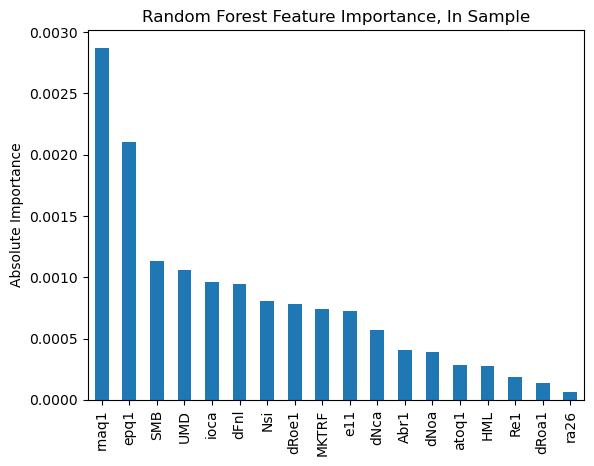

In [454]:
forest_importances.sort_values(ascending=False).plot(kind="bar", title="Random Forest Feature Importance, In Sample", ylabel="Absolute Importance")

<AxesSubplot:>

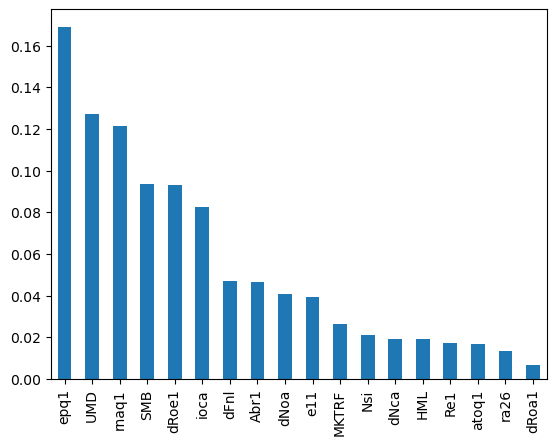

In [453]:
# Using default RF feature importance
importances = pd.Series(model.final_trained_models["RandomForest"].feature_importances_, index=FEATURES).sort_values(ascending=False)
importances.plot(kind="bar")

### SHAP Explain on Validation Set

In [407]:
import shap
explainer = shap.TreeExplainer(final["RandomForest"])
shap_values = explainer.shap_values(model.x_validate)

AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

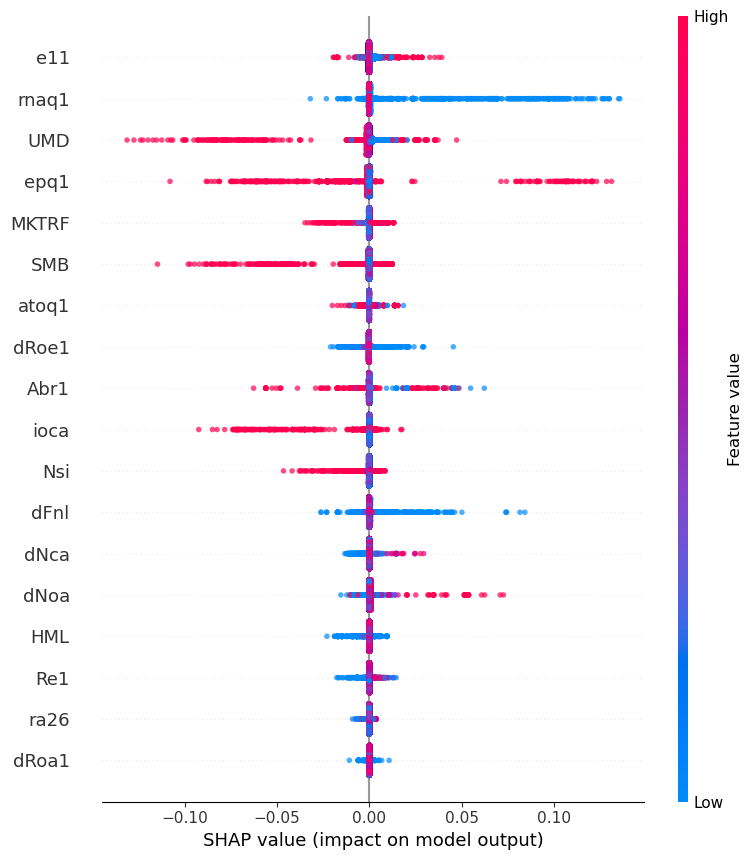

In [445]:
shap.summary_plot(shap_values, model.x_validate, alpha=0.7)

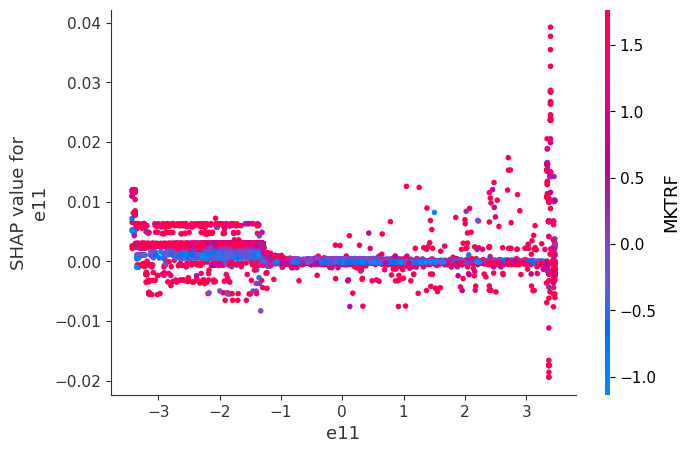

In [ ]:
shap.dependence_plot("e11", shap_values, model.x_validate)

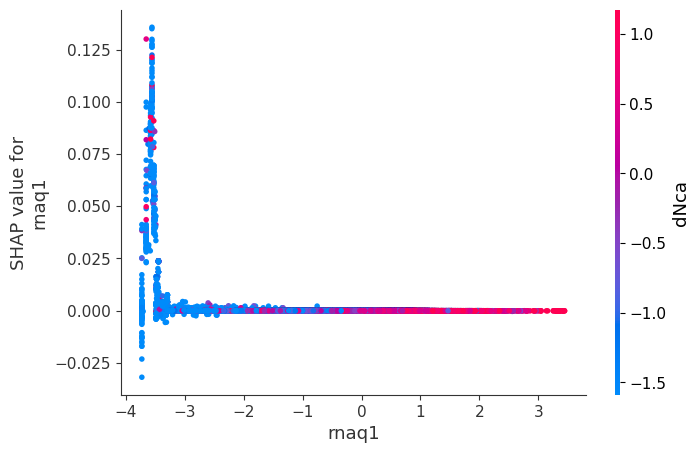

In [444]:
shap.dependence_plot("rnaq1", shap_values, model.x_validate)

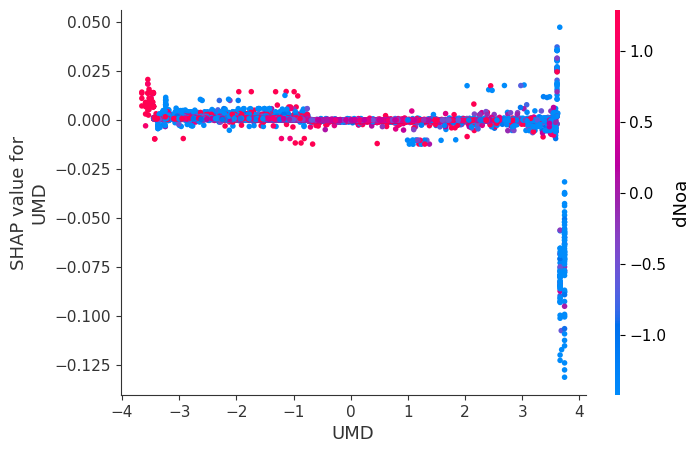

In [449]:
shap.dependence_plot("UMD", shap_values, model.x_validate)

# Old Code

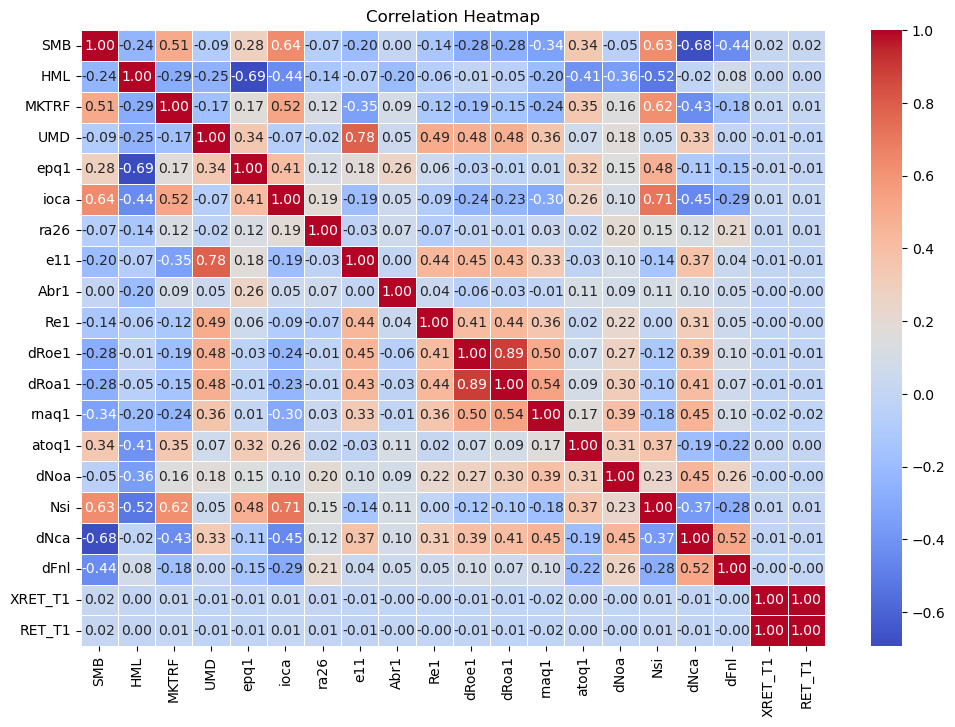

In [ ]:
cleaned = ml_data
correlation_matrix = cleaned.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [165]:
# data = pd.read_csv("assets.zip")

X = ml_data.dropna()[['SMB', 'HML', 'MKTRF', 'UMD', 'epq1', 'ioca', 'ra26', 'e11', 'Abr1', 'Re1', 'dRoe1', 'dRoa1', 'rnaq1', 'atoq1', 'dNoa', 'Nsi', 'dNca', 'dFnl']]
y = ml_data.dropna()['XRET_T1']

# this has lookahead bias, we just dropped NA (not ideal, instead should fill Na with cross sectional mean, then drop Na)
# X.fillna(X.mean(), inplace=True)
# y.fillna(y.mean(), inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)

predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)


Mean Squared Error: 0.015662521205462757


In [141]:
model = sm.OLS(y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                XRET_T1   R-squared (uncentered):                   0.740
Model:                            OLS   Adj. R-squared (uncentered):              0.740
Method:                 Least Squares   F-statistic:                          1.312e+05
Date:                Wed, 24 Apr 2024   Prob (F-statistic):                        0.00
Time:                        00:24:45   Log-Likelihood:                     -1.6239e+05
No. Observations:              829176   AIC:                                  3.248e+05
Df Residuals:                  829158   BIC:                                  3.250e+05
Df Model:                          18                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
SMB            0.1162      0.002     64.353      0.000       0.113       0.120
HML            0.2254      0.001    182.576      0.000       0.223       0.228
MKTRF          0.0647      0.002     41.865      0.000       0.062       0.068
UMD           -0.0258      0.002    -13.234      0.000      -0.030      -0.022
epq1           0.1039      0.002     68.227      0.000       0.101       0.107
ioca           0.0856      0.002     50.318      0.000       0.082       0.089
ra26           0.0208      0.001     17.183      0.000       0.018       0.023
e11            0.0293      0.002     16.017      0.000       0.026       0.033
Abr1           0.0297      0.001     25.401      0.000       0.027       0.032
Re1            0.0143      0.001     10.621      0.000       0.012       0.017
dRoe1          0.0093      0.002      3.915      0.000       0.005       0.014
dRoa1          0.0031      0.002      1.280      0.201      -0.002       0.008
rnaq1          0.0915      0.001     63.434      0.000       0.089       0.094
atoq1          0.0501      0.001     36.636      0.000       0.047       0.053
dNoa          -0.0550      0.002    -34.953      0.000      -0.058      -0.052
Nsi            0.0052      0.002      2.682      0.007       0.001       0.009
dNca           0.1538      0.002     81.833      0.000       0.150       0.158
dFnl           0.0643      0.001     47.558      0.000       0.062       0.067
==============================================================================
Omnibus:                   293311.650   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            39944.990
Skew:                          -0.008   Prob(JB):                         0.00
Kurtosis:                       1.925   Cond. No.                         21.8
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [352]:
data = pd.read_csv("assets.zip")

X = data[['SMB', 'HML', 'MKTRF', 'RF', 'UMD', 'monthid', 'epq1', 'ioca', 'ra26', 'e11', 'Re1', 'dRoe1', 'dRoa1', 'rnaq1', 'atoq1', 'dNoa', 'Nsi', 'dNca', 'dFnl']]
y = data['RET']

X.fillna(X.mean(), inplace=True)
y.fillna(y.mean(), inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)

predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)


In [353]:
coefficients = model.coef_

coefficients_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})
coefficients_df['Absolute_Coefficient'] = abs(coefficients_df['Coefficient'])
sorted_coefficients_df = coefficients_df.sort_values(by='Absolute_Coefficient', ascending=False)

print(sorted_coefficients_df)

plt.figure(figsize=(10, 6))
plt.barh(sorted_coefficients_df['Feature'], sorted_coefficients_df['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Coefficients of Features')
plt.show()


In [ ]:
highest_correlation_pairs = correlation_matrix.unstack().sort_values(ascending=False)
highest_correlation_pairs = highest_correlation_pairs[highest_correlation_pairs != 1].drop_duplicates()

print(highest_correlation_pairs.head())

dRoa1  dRoe1    0.895938
ioca   Nsi      0.776612
UMD    e11      0.730722
Nsi    epq1     0.621109
dNoa   dNca     0.614551
dtype: float64
